In [43]:
# Bruno Ugolini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import requests
import json
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import gensim
import gensim.downloader as model_api

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


# Question 1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

### First, bring in the code from the last assignment.

In [2]:
# App names and id's
apps = {'Candy Crush': 553834731, 'Tinder': 547702041, 'Facebook': 284882215, 'Twitter': 333903271}
en_cc = ['us', 'ca', 'gb', 'au', 'nz']
col_names = ['im:version', 'im:rating', 'id', 'title', 'content', 'im:voteSum', 'im:voteCount']
col2_names = {'author': 'name', 'im:contentType': 'attributes'}
col3_names = {'link': 'attributes'}
df_master = pd.DataFrame()
for app, idx in apps.items():
    for cc in en_cc:
        cnt = 0 # number of reviews counter
        for i in range(1,11): # api limits to 10 pages
            df = pd.DataFrame()
            r = requests.get(f"https://itunes.apple.com/{cc}/rss/customerreviews/id={idx}/page={i}/sortby=mostrecent/json")
            if r.status_code == 200:
                d = json.loads(r.content)
                df = pd.DataFrame.from_dict(d['feed']['entry'])
                # do columns where 'label' is accessible
                for col in col_names:
                    df[col] = df[col].apply(lambda x: x['label'])
                # do columns where 'label' is one layer deeper
                for col, attr in col2_names.items():
                    df[col] = df[col].apply(lambda x: x[attr]['label'])
                # do columns where 'href' is the desired name
                for col, attr in col3_names.items():
                    df[col] = df[col].apply(lambda x: x[attr]['href'])
                # add country and app title
                df['title'] = app
                df['country'] = cc
                cnt += len(df)
                df_master = pd.concat([df_master,df],axis=0,ignore_index=True)
        print(f"There were {cnt} reviews for {app} in {cc}.")

There were 500 reviews for Candy Crush in us.
There were 500 reviews for Candy Crush in ca.
There were 500 reviews for Candy Crush in gb.
There were 500 reviews for Candy Crush in au.
There were 500 reviews for Candy Crush in nz.
There were 500 reviews for Tinder in us.
There were 500 reviews for Tinder in ca.
There were 500 reviews for Tinder in gb.
There were 500 reviews for Tinder in au.
There were 500 reviews for Tinder in nz.
There were 500 reviews for Facebook in us.
There were 500 reviews for Facebook in ca.
There were 500 reviews for Facebook in gb.
There were 500 reviews for Facebook in au.
There were 500 reviews for Facebook in nz.
There were 500 reviews for Twitter in us.
There were 500 reviews for Twitter in ca.
There were 500 reviews for Twitter in gb.
There were 500 reviews for Twitter in au.
There were 500 reviews for Twitter in nz.


### Bag of words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [5]:
X = vectorizer.fit_transform(df_master['content'])
wordLabels = vectorizer.get_feature_names()

pd.DataFrame(data=X.toarray(), columns=wordLabels).sample(8)

,00,000,000km,01,02,06,07,0932980601,10,100,...,틴저,하고,학생입니따,한번도,할게요,항상,해주었습니다,했지만,힘들어할때,𝘩𝘢𝘷𝘦
4041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4050,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_master['im:rating'] = df_master['im:rating'].astype(int)

In [21]:
COMPRESSED_SIZE = 6000
#   Compressed_size =  200 --> R-squared of 0.303
#   Compressed_size =  500 --> R-squared of 0.380
#   Compressed_size = 1500 --> R-squared of 0.480
#   Compressed_size = 3000 --> R-squared of 0.582
#   Compressed_size = 6000 --> R-squared of 0.777

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [22]:
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df_master['im:rating'].values
print("OLS R^2: ", r2_score(df_master['im:rating'], pred))

OLS R^2:  0.7774029188221921


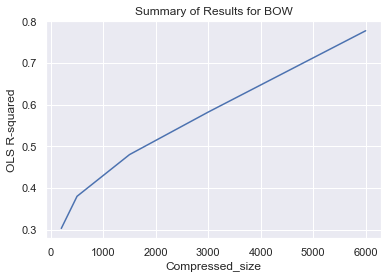

In [24]:
sns.set()
plt.plot([200,500,1500,3000,6000],[0.303, 0.380, 0.480, 0.582,0.777])
plt.title('Summary of Results for BOW')
plt.xlabel('Compressed_size')
plt.ylabel('OLS R-squared');

### TF-IDF

In [26]:
import sklearn.feature_extraction.text as text

In [38]:
COMPRESSED_SIZE = 6000
#   Compressed_size =  200 --> R-squared of 0.473
#   Compressed_size =  500 --> R-squared of 0.531
#   Compressed_size = 1500 --> R-squared of 0.619
#   Compressed_size = 3000 --> R-squared of 0.717
#   Compressed_size = 6000 --> R-squared of 0.846

tf = text.TfidfVectorizer()
X = tf.fit_transform(df_master['content'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [39]:
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df_master['im:rating'].values
print("OLS R^2: ", r2_score(df_master['im:rating'], pred))

OLS R^2:  0.8457341970886729


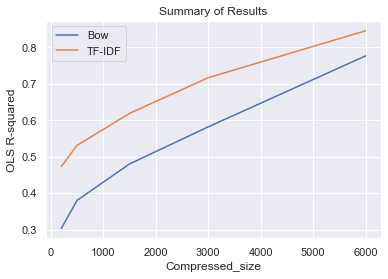

In [41]:
sns.set()
plt.plot([200,500,1500,3000,6000],[0.303, 0.380, 0.480, 0.582,0.777],label='Bow')
plt.plot([200,500,1500,3000,6000],[0.473, 0.531, 0.619, 0.717,0.846],label='TF-IDF')
plt.title('Summary of Results')
plt.xlabel('Compressed_size')
plt.ylabel('OLS R-squared')
plt.legend();

# Question 1.2 Now use a sentence embedding using on of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

   ### Following the course notes, let's import the word vectors

In [197]:
model_api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [233]:
#word_vectors = model_api.load("glove-wiki-gigaword-50")
word_vectors = model_api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


### Create the split-word dataframe from our 'content' column

In [234]:
import re

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df_master.content.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [235]:
words.head(3)

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,y,muy,dulce,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,i’ve,been,playing,for,years,not,only,have,i,never,...,None,None,None,None,None,None,None,None,None,None
2,can’t,get,game,to,load,someone,help,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [236]:
def soft_get(w):
#    print(f"\tword: {w}")
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
def map_vectors(row):
#    print(row)
    if np.sum(row.notna()) == 0:
        return np.zeros(word_vectors.vector_size)
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.481687,0.235146,-0.429474,-1.139827,0.085650,0.386470,0.146140,-0.248890,0.157715,-0.138871,...,0.362364,-0.406064,1.229400,2.576010,-0.251729,0.922290,-1.062815,-1.309550,-1.545526,-0.735070
1,-1.472753,5.908627,7.110304,3.651183,-5.209724,5.575743,3.855471,0.872604,1.776759,-3.516171,...,-1.705603,3.849659,-0.407718,-1.076752,-5.273182,-3.794676,-3.085020,-3.194255,7.686192,0.897375
2,1.959890,2.387232,0.678190,-0.519988,0.602743,-0.165815,2.804163,0.537965,1.676630,1.305500,...,-2.489987,0.371549,-0.408825,0.540090,1.455781,-1.319027,-0.259136,-0.589350,0.453055,0.646575
3,1.904520,0.880153,0.916477,-3.013660,1.245429,3.730315,1.842614,0.287908,-0.882696,0.136028,...,-2.293519,0.493918,-3.247869,-1.014032,2.209543,0.670044,0.767227,0.505266,-1.219353,-1.142193
4,4.313720,5.460218,2.992490,1.103080,-3.403285,9.030437,9.022041,-3.559283,4.872637,2.807665,...,-6.056370,1.324138,0.853339,-1.500276,-2.716699,-3.549805,-0.355281,-3.697781,6.511583,1.738170


In [246]:
Xd = emb.to_numpy()
#Xd = PCA(25).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df_master['im:rating'].values
print("OLS R^2: ", r2_score(df_master['im:rating'], pred))

OLS R^2:  0.26569811722582637


In [248]:
sgdr = SGDRegressor(loss='epsilon_insensitive',verbose=0,learning_rate='adaptive')
#'epsilon_insensitive', or 'squared_epsilon_insensitive'
sgdr.fit(emb, df_master['im:rating'])
sgdr.score(emb, df_master['im:rating'])

0.24426605594439887

# Question 1.3 Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

In [249]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_master['content'])
wordLabels = vectorizer.get_feature_names()
COMPRESSED_SIZE = 6000
tf = text.TfidfVectorizer()
X = tf.fit_transform(df_master['content'])
Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [250]:
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df_master['im:rating'].values
print("OLS R^2: ", r2_score(df_master['im:rating'], pred))

OLS R^2:  0.8451838958691753


In [251]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [255]:
confusion_matrix(df_master['im:rating'],np.round(pred))

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,  362, 4213, 1195,  127,    9,    1,    0,    0],
       [   0,    1,  146,  605,  100,    5,    1,    0,    0],
       [   0,    0,   18,  179,  411,   42,    6,    0,    0],
       [   0,    0,    5,   42,  142,  294,   59,    4,    0],
       [   0,    0,    1,   23,  170,  444, 1327,   62,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [257]:
print(classification_report(df_master['im:rating'],np.round(pred)))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00         0
         1.0       0.96      0.71      0.82      5910
         2.0       0.30      0.71      0.42       858
         3.0       0.43      0.63      0.51       656
         4.0       0.37      0.54      0.44       546
         5.0       0.95      0.65      0.78      2030
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0

    accuracy                           0.69     10000
   macro avg       0.33      0.36      0.33     10000
weighted avg       0.84      0.69      0.73     10000



D:\Users\Pinhead\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result